In [3]:
"""
Financial Text Summarization Project
Comprehensive Implementation for SEC 10-K/10-Q Filings Analysis
Optimized for Google Colab/Kaggle with GPU Support

Team: Eman Sarfraz & Ahmad Yasin
Project: Domain-Specific Abstractive Summarization in Financial Sector
"""

# ============================================================================
# SECTION 1: INSTALLATION AND SETUP
# ============================================================================

# Install required packages (run this cell first in Colab/Kaggle)
!pip install transformers datasets torch torchvision torchaudio
!pip install sentence-transformers
!pip install rouge-score bert-score
!pip install peft accelerate
!pip install beautifulsoup4 lxml requests
!pip install PyPDF2 pdfplumber
!pip install networkx scipy scikit-learn
!pip install plotly matplotlib seaborn
!pip install sec-edgar-downloader

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.3 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=d307e6d85a617da5e3a5d5c501d1c083d6384fffa076c86870913d003146fc2f
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 36.8 MB/s eta 0:00:00


In [15]:
# ============================================================================
# SECTION 2: IMPORTS
# ============================================================================

import os
import re
import json
import time
import pickle
import warnings
from typing import List, Dict, Tuple, Optional
from pathlib import Path
from datetime import datetime
from collections import defaultdict

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and ML
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Transformers and PEFT
from transformers import (
    BartTokenizer, BartForConditionalGeneration,
    TrainingArguments, Trainer, DataCollatorForSeq2Seq
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from accelerate import Accelerator

# Sentence embeddings
from sentence_transformers import SentenceTransformer

# Web scraping and file processing
import requests
from bs4 import BeautifulSoup
import PyPDF2
import pdfplumber

# Evaluation
from rouge_score import rouge_scorer
from bert_score import score as bert_score

# Graph-based methods
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Dataset handling
from datasets import Dataset as HFDataset

warnings.filterwarnings('ignore')

# Download NLTK data
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('punkt_tab', quiet=True) # Added this line
except:
    pass


In [5]:
# ============================================================================
# SECTION 3: CONFIGURATION AND DEVICE SETUP
# ============================================================================

class Config:
    """Central configuration for the project"""

    # Paths
    DATA_DIR = "./financial_data"
    MODEL_DIR = "./models"
    RESULTS_DIR = "./results"
    CACHE_DIR = "./cache"

    # Model parameters
    BART_MODEL = "facebook/bart-large-cnn"
    SBERT_MODEL = "all-MiniLM-L6-v2"
    MAX_INPUT_LENGTH = 1024
    MAX_OUTPUT_LENGTH = 256

    # Training parameters
    BATCH_SIZE = 4
    LEARNING_RATE = 3e-5
    NUM_EPOCHS = 3
    WARMUP_STEPS = 500
    WEIGHT_DECAY = 0.01

    # LoRA parameters
    LORA_R = 16
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.1

    # TextRank parameters
    TEXTRANK_RATIO = 0.2  # Extract 20% of sentences
    TEXTRANK_MIN_SENTENCES = 3
    TEXTRANK_MAX_SENTENCES = 10

    # Evaluation
    ROUGE_TYPES = ['rouge1', 'rouge2', 'rougeL']

    # Create directories
    @staticmethod
    def setup_directories():
        for dir_path in [Config.DATA_DIR, Config.MODEL_DIR,
                         Config.RESULTS_DIR, Config.CACHE_DIR]:
            Path(dir_path).mkdir(parents=True, exist_ok=True)

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Config.setup_directories()

Using device: cuda
GPU: Tesla T4
Memory: 15.83 GB


In [17]:
# ============================================================================
# SECTION 4: DATA COLLECTION AND PREPROCESSING
# ============================================================================

class SECDataCollector:
    """Collect SEC 10-K/10-Q filings"""

    def __init__(self, save_dir: str = Config.DATA_DIR):
        self.save_dir = save_dir
        self.base_url = "https://www.sec.gov"

    def download_sample_filings(self, num_samples: int = 100) -> List[Dict]:
        """
        Download sample SEC filings
        Note: For production, use sec-edgar-downloader library
        This is a simplified version for demonstration
        """
        print(f"Collecting {num_samples} sample SEC filings...")

        # For this implementation, we'll create a structure for the data
        # In production, you would use: from sec_edgar_downloader import Downloader

        filings = []

        # Placeholder: In actual implementation, download real filings
        # For now, we'll structure it to work with manually downloaded data
        print("Note: Place downloaded SEC filings in the data directory")
        print("Use sec-edgar-downloader for automated collection")

        return filings

    def extract_text_from_html(self, html_content: str) -> str:
        """Extract text from HTML filing"""
        soup = BeautifulSoup(html_content, 'lxml')

        # Remove scripts and styles
        for script in soup(["script", "style"]):
            script.decompose()

        # Get text
        text = soup.get_text()

        # Clean text
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        text = ' '.join(chunk for chunk in chunks if chunk)

        return text

    def extract_text_from_pdf(self, pdf_path: str) -> str:
        """Extract text from PDF filing"""
        text = ""

        try:
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    text += page.extract_text() + "\n"
        except:
            # Fallback to PyPDF2
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                for page in pdf_reader.pages:
                    text += page.extract_text() + "\n"

        return text


class TextPreprocessor:
    """Preprocess financial text for summarization"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

        # Financial boilerplate patterns to remove
        self.boilerplate_patterns = [
            r'UNITED STATES SECURITIES AND EXCHANGE COMMISSION.*?Form 10-[KQ]',
            r'Table of Contents',
            r'SIGNATURE[S]?.*',
            r'EXHIBIT INDEX.*',
        ]

        # Financial term patterns
        self.currency_pattern = r'\$\s*(\d+(?:,\d{3})*(?:\.\d+)?)\s*(million|billion|M|B)?'

    def clean_text(self, text: str) -> str:
        """Clean and normalize text"""

        # Remove boilerplate
        for pattern in self.boilerplate_patterns:
            text = re.sub(pattern, '', text, flags=re.IGNORECASE | re.DOTALL)

        # Normalize whitespace
        text = re.sub(r'\s+', ' ', text)

        # Normalize currency
        text = self._normalize_currency(text)

        # Remove special characters but keep sentence structure
        text = re.sub(r'[^\w\s\.\,\!\?\;\:\-\$\%]', '', text)

        return text.strip()

    def _normalize_currency(self, text: str) -> str:
        """Normalize currency expressions"""

        def replace_currency(match):
            amount = match.group(1).replace(',', '')
            unit = match.group(2)

            if unit in ['million', 'M']:
                return f"${amount} million"
            elif unit in ['billion', 'B']:
                return f"${amount} billion"
            else:
                return f"${amount}"

        return re.sub(self.currency_pattern, replace_currency, text)

    def split_into_sentences(self, text: str) -> List[str]:
        """Split text into sentences"""
        sentences = sent_tokenize(text)

        # Filter out very short or very long sentences
        filtered = []
        for sent in sentences:
            word_count = len(sent.split())
            if 5 <= word_count <= 100:  # Reasonable sentence length
                filtered.append(sent)

        return filtered

    def chunk_text(self, text: str, max_tokens: int = 1024,
                   tokenizer=None) -> List[str]:
        """Chunk text to fit model input limits"""

        if tokenizer is None:
            # Simple word-based chunking
            words = text.split()
            chunks = []
            current_chunk = []
            current_length = 0

            for word in words:
                current_length += 1
                current_chunk.append(word)

                if current_length >= max_tokens:
                    chunks.append(' '.join(current_chunk))
                    current_chunk = []
                    current_length = 0

            if current_chunk:
                chunks.append(' '.join(current_chunk))

            return chunks
        else:
            # Token-based chunking
            sentences = self.split_into_sentences(text)
            chunks = []
            current_chunk = []
            current_length = 0

            for sent in sentences:
                tokens = tokenizer.encode(sent, add_special_tokens=False)
                sent_length = len(tokens)

                if current_length + sent_length > max_tokens:
                    if current_chunk:
                        chunks.append(' '.join(current_chunk))
                    current_chunk = [sent]
                    current_length = sent_length
                else:
                    current_chunk.append(sent)
                    current_length += sent_length

            if current_chunk:
                chunks.append(' '.join(current_chunk))

            return chunks

In [7]:
# ============================================================================
# SECTION 5: TEXTRANK EXTRACTIVE SUMMARIZATION
# ============================================================================

class TextRankSummarizer:
    """TextRank-based extractive summarization with enhancements"""

    def __init__(self,
                 use_sbert: bool = True,
                 sbert_model: str = Config.SBERT_MODEL):
        """
        Initialize TextRank summarizer

        Args:
            use_sbert: Use Sentence-BERT embeddings for similarity
            sbert_model: Sentence-BERT model name
        """
        self.use_sbert = use_sbert

        if use_sbert:
            print(f"Loading Sentence-BERT model: {sbert_model}")
            self.sbert = SentenceTransformer(sbert_model)
        else:
            self.sbert = None

        self.preprocessor = TextPreprocessor()

    def _compute_similarity_matrix(self, sentences: List[str]) -> np.ndarray:
        """Compute sentence similarity matrix"""

        if self.use_sbert and self.sbert is not None:
            # Use SBERT embeddings
            embeddings = self.sbert.encode(sentences)
            similarity_matrix = cosine_similarity(embeddings)
        else:
            # Use TF-IDF
            vectorizer = TfidfVectorizer()
            tfidf_matrix = vectorizer.fit_transform(sentences)
            similarity_matrix = cosine_similarity(tfidf_matrix)

        return similarity_matrix

    def _build_graph(self, similarity_matrix: np.ndarray) -> nx.Graph:
        """Build graph from similarity matrix"""
        graph = nx.Graph()
        n = len(similarity_matrix)

        # Add edges with weights
        for i in range(n):
            for j in range(i + 1, n):
                weight = similarity_matrix[i][j]
                if weight > 0:
                    graph.add_edge(i, j, weight=weight)

        return graph

    def summarize(self,
                  text: str,
                  ratio: float = Config.TEXTRANK_RATIO,
                  min_sentences: int = Config.TEXTRANK_MIN_SENTENCES,
                  max_sentences: int = Config.TEXTRANK_MAX_SENTENCES) -> str:
        """
        Generate extractive summary using TextRank

        Args:
            text: Input text
            ratio: Ratio of sentences to extract
            min_sentences: Minimum number of sentences
            max_sentences: Maximum number of sentences

        Returns:
            Extractive summary
        """
        # Preprocess and split into sentences
        cleaned_text = self.preprocessor.clean_text(text)
        sentences = self.preprocessor.split_into_sentences(cleaned_text)

        if len(sentences) <= min_sentences:
            return ' '.join(sentences)

        # Compute similarity matrix
        similarity_matrix = self._compute_similarity_matrix(sentences)

        # Build graph
        graph = self._build_graph(similarity_matrix)

        # Apply PageRank
        try:
            scores = nx.pagerank(graph, weight='weight')
        except:
            # Fallback if graph is disconnected
            scores = {i: 1.0 / len(sentences) for i in range(len(sentences))}

        # Rank sentences
        ranked_sentences = sorted(scores.items(),
                                 key=lambda x: x[1],
                                 reverse=True)

        # Select top sentences
        num_sentences = min(
            max(int(len(sentences) * ratio), min_sentences),
            max_sentences
        )

        # Get indices of top sentences and sort by original order
        top_indices = sorted([idx for idx, _ in ranked_sentences[:num_sentences]])

        # Extract sentences
        summary_sentences = [sentences[idx] for idx in top_indices]
        summary = ' '.join(summary_sentences)

        return summary

    def batch_summarize(self, texts: List[str], **kwargs) -> List[str]:
        """Summarize multiple texts"""
        summaries = []

        for i, text in enumerate(texts):
            if (i + 1) % 10 == 0:
                print(f"TextRank: Processing {i + 1}/{len(texts)}")

            summary = self.summarize(text, **kwargs)
            summaries.append(summary)

        return summaries


In [8]:
# ============================================================================
# SECTION 6: BART ABSTRACTIVE SUMMARIZATION WITH LORA
# ============================================================================

class FinancialSummarizationDataset(Dataset):
    """Dataset for financial document summarization"""

    def __init__(self,
                 documents: List[str],
                 summaries: List[str],
                 tokenizer,
                 max_input_length: int = Config.MAX_INPUT_LENGTH,
                 max_output_length: int = Config.MAX_OUTPUT_LENGTH):

        self.documents = documents
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        document = self.documents[idx]
        summary = self.summaries[idx]

        # Tokenize inputs
        model_inputs = self.tokenizer(
            document,
            max_length=self.max_input_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )

        # Tokenize targets
        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(
                summary,
                max_length=self.max_output_length,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )

        model_inputs['labels'] = labels['input_ids']

        # Remove batch dimension
        return {k: v.squeeze(0) for k, v in model_inputs.items()}


class BARTSummarizer:
    """BART-based abstractive summarization with LoRA fine-tuning"""

    def __init__(self,
                 model_name: str = Config.BART_MODEL,
                 use_lora: bool = True):
        """
        Initialize BART summarizer

        Args:
            model_name: Pretrained BART model name
            use_lora: Use LoRA for parameter-efficient fine-tuning
        """
        self.model_name = model_name
        self.use_lora = use_lora
        self.device = device

        print(f"Loading BART model: {model_name}")
        self.tokenizer = BartTokenizer.from_pretrained(model_name)
        self.model = BartForConditionalGeneration.from_pretrained(model_name)

        if use_lora:
            self._apply_lora()

        self.model.to(self.device)
        self.preprocessor = TextPreprocessor()

    def _apply_lora(self):
        """Apply LoRA to the model"""
        print("Applying LoRA configuration...")

        lora_config = LoraConfig(
            task_type=TaskType.SEQ_2_SEQ_LM,
            r=Config.LORA_R,
            lora_alpha=Config.LORA_ALPHA,
            lora_dropout=Config.LORA_DROPOUT,
            target_modules=["q_proj", "v_proj"]
        )

        self.model = get_peft_model(self.model, lora_config)
        self.model.print_trainable_parameters()

    def prepare_dataset(self,
                       documents: List[str],
                       summaries: List[str]) -> HFDataset:
        """Prepare dataset for training"""

        dataset = FinancialSummarizationDataset(
            documents, summaries, self.tokenizer
        )

        return dataset

    def train(self,
              train_documents: List[str],
              train_summaries: List[str],
              val_documents: Optional[List[str]] = None,
              val_summaries: Optional[List[str]] = None,
              output_dir: str = Config.MODEL_DIR):
        """
        Fine-tune BART model

        Args:
            train_documents: Training documents
            train_summaries: Training summaries
            val_documents: Validation documents
            val_summaries: Validation summaries
            output_dir: Directory to save model
        """
        print("Preparing training dataset...")
        train_dataset = self.prepare_dataset(train_documents, train_summaries)

        eval_dataset = None
        if val_documents and val_summaries:
            print("Preparing validation dataset...")
            eval_dataset = self.prepare_dataset(val_documents, val_summaries)

        # Training arguments
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=Config.NUM_EPOCHS,
            per_device_train_batch_size=Config.BATCH_SIZE,
            per_device_eval_batch_size=Config.BATCH_SIZE,
            warmup_steps=Config.WARMUP_STEPS,
            weight_decay=Config.WEIGHT_DECAY,
            learning_rate=Config.LEARNING_RATE,
            logging_dir=f"{output_dir}/logs",
            logging_steps=100,
            eval_strategy="steps" if eval_dataset else "no",
            eval_steps=500 if eval_dataset else None,
            save_strategy="steps",
            save_steps=1000,
            load_best_model_at_end=True if eval_dataset else False,
            metric_for_best_model="eval_loss" if eval_dataset else None,
            gradient_checkpointing=True,
            fp16=torch.cuda.is_available(),
            report_to="none"
        )

        # Data collator
        data_collator = DataCollatorForSeq2Seq(
            self.tokenizer,
            model=self.model
        )

        # Trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
            data_collator=data_collator,
            tokenizer=self.tokenizer
        )

        # Train
        print("Starting training...")
        trainer.train()

        # Save model
        print(f"Saving model to {output_dir}")
        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)

    def summarize(self,
                  text: str,
                  max_length: int = Config.MAX_OUTPUT_LENGTH,
                  min_length: int = 50,
                  num_beams: int = 4) -> str:
        """
        Generate abstractive summary

        Args:
            text: Input text
            max_length: Maximum summary length
            min_length: Minimum summary length
            num_beams: Number of beams for beam search

        Returns:
            Abstractive summary
        """
        # Prepare input
        inputs = self.tokenizer(
            text,
            max_length=Config.MAX_INPUT_LENGTH,
            truncation=True,
            return_tensors='pt'
        ).to(self.device)

        # Generate summary
        with torch.no_grad():
            summary_ids = self.model.generate(
                inputs['input_ids'],
                max_length=max_length,
                min_length=min_length,
                num_beams=num_beams,
                length_penalty=2.0,
                early_stopping=True
            )

        # Decode summary
        summary = self.tokenizer.decode(
            summary_ids[0],
            skip_special_tokens=True
        )

        return summary

    def batch_summarize(self,
                       texts: List[str],
                       batch_size: int = 8,
                       **kwargs) -> List[str]:
        """Summarize multiple texts in batches"""
        summaries = []

        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]

            if (i // batch_size + 1) % 5 == 0:
                print(f"BART: Processing batch {i // batch_size + 1}/{len(texts) // batch_size + 1}")

            # Tokenize batch
            inputs = self.tokenizer(
                batch,
                max_length=Config.MAX_INPUT_LENGTH,
                truncation=True,
                padding=True,
                return_tensors='pt'
            ).to(self.device)

            # Generate summaries
            with torch.no_grad():
                summary_ids = self.model.generate(
                    inputs['input_ids'],
                    max_length=kwargs.get('max_length', Config.MAX_OUTPUT_LENGTH),
                    min_length=kwargs.get('min_length', 50),
                    num_beams=kwargs.get('num_beams', 4),
                    length_penalty=2.0,
                    early_stopping=True
                )

            # Decode summaries
            batch_summaries = self.tokenizer.batch_decode(
                summary_ids,
                skip_special_tokens=True
            )

            summaries.extend(batch_summaries)

        return summaries


In [9]:
# ============================================================================
# SECTION 7: EVALUATION METRICS
# ============================================================================

class EvaluationMetrics:
    """Comprehensive evaluation metrics for summarization"""

    def __init__(self):
        self.rouge_scorer = rouge_scorer.RougeScorer(
            Config.ROUGE_TYPES,
            use_stemmer=True
        )

    def compute_rouge(self,
                     predictions: List[str],
                     references: List[str]) -> Dict[str, float]:
        """Compute ROUGE scores"""

        scores = {rouge_type: [] for rouge_type in Config.ROUGE_TYPES}

        for pred, ref in zip(predictions, references):
            rouge_scores = self.rouge_scorer.score(ref, pred)

            for rouge_type in Config.ROUGE_TYPES:
                scores[rouge_type].append(rouge_scores[rouge_type].fmeasure)

        # Average scores
        avg_scores = {
            rouge_type: np.mean(scores[rouge_type])
            for rouge_type in Config.ROUGE_TYPES
        }

        return avg_scores

    def compute_bertscore(self,
                         predictions: List[str],
                         references: List[str]) -> Dict[str, float]:
        """Compute BERTScore"""

        print("Computing BERTScore (this may take a while)...")

        P, R, F1 = bert_score(
            predictions,
            references,
            lang='en',
            device=device,
            verbose=False
        )

        return {
            'precision': P.mean().item(),
            'recall': R.mean().item(),
            'f1': F1.mean().item()
        }

    def compute_factcc_proxy(self,
                           predictions: List[str],
                           references: List[str]) -> float:
        """
        Compute factual consistency proxy
        Note: This is a simplified version. For production, use FactCC model
        """

        # Use BERTScore F1 as a proxy for factual consistency
        # Higher semantic similarity suggests better factual alignment
        _, _, F1 = bert_score(
            predictions,
            references,
            lang='en',
            device=device,
            verbose=False
        )

        return F1.mean().item()

    def measure_inference_time(self,
                              summarizer,
                              texts: List[str],
                              method: str = 'textrank') -> Dict[str, float]:
        """Measure inference time"""

        start_time = time.time()

        if method.lower() == 'textrank':
            _ = summarizer.batch_summarize(texts)
        else:  # BART
            _ = summarizer.batch_summarize(texts, batch_size=8)

        end_time = time.time()

        total_time = end_time - start_time
        avg_time = total_time / len(texts)

        return {
            'total_time': total_time,
            'avg_time_per_doc': avg_time,
            'docs_per_second': len(texts) / total_time
        }

    def comprehensive_evaluation(self,
                               textrank_summaries: List[str],
                               bart_summaries: List[str],
                               references: List[str]) -> Dict:
        """Perform comprehensive evaluation of both models"""

        print("\n" + "="*80)
        print("COMPREHENSIVE EVALUATION")
        print("="*80)

        results = {
            'textrank': {},
            'bart': {}
        }

        # TextRank evaluation
        print("\nEvaluating TextRank...")
        print("-" * 40)

        results['textrank']['rouge'] = self.compute_rouge(
            textrank_summaries, references
        )
        print(f"ROUGE Scores: {results['textrank']['rouge']}")

        results['textrank']['bertscore'] = self.compute_bertscore(
            textrank_summaries, references
        )
        print(f"BERTScore: {results['textrank']['bertscore']}")

        results['textrank']['factcc_proxy'] = self.compute_factcc_proxy(
            textrank_summaries, references
        )
        print(f"Factual Consistency (proxy): {results['textrank']['factcc_proxy']:.4f}")

        # BART evaluation
        print("\nEvaluating BART...")
        print("-" * 40)

        results['bart']['rouge'] = self.compute_rouge(
            bart_summaries, references
        )
        print(f"ROUGE Scores: {results['bart']['rouge']}")

        results['bart']['bertscore'] = self.compute_bertscore(
            bart_summaries, references
        )
        print(f"BERTScore: {results['bart']['bertscore']}")

        results['bart']['factcc_proxy'] = self.compute_factcc_proxy(
            bart_summaries, references
        )
        print(f"Factual Consistency (proxy): {results['bart']['factcc_proxy']:.4f}")

        return results


In [10]:
# ============================================================================
# SECTION 8: VISUALIZATION
# ============================================================================

class ResultsVisualizer:
    """Visualize comparison results"""

    def __init__(self, results: Dict, save_dir: str = Config.RESULTS_DIR):
        self.results = results
        self.save_dir = save_dir
        Path(save_dir).mkdir(parents=True, exist_ok=True)

    def plot_rouge_comparison(self):
        """Plot ROUGE score comparison"""

        fig, ax = plt.subplots(figsize=(10, 6))

        rouge_types = list(self.results['textrank']['rouge'].keys())
        textrank_scores = [self.results['textrank']['rouge'][rt] for rt in rouge_types]
        bart_scores = [self.results['bart']['rouge'][rt] for rt in rouge_types]

        x = np.arange(len(rouge_types))
        width = 0.35

        ax.bar(x - width/2, textrank_scores, width, label='TextRank', alpha=0.8)
        ax.bar(x + width/2, bart_scores, width, label='BART', alpha=0.8)

        ax.set_xlabel('ROUGE Metric', fontsize=12)
        ax.set_ylabel('F1 Score', fontsize=12)
        ax.set_title('ROUGE Score Comparison: TextRank vs BART', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(rouge_types)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/rouge_comparison.png", dpi=300)
        plt.show()

        print(f"Saved: {self.save_dir}/rouge_comparison.png")

    def plot_bertscore_comparison(self):
        """Plot BERTScore comparison"""

        fig, ax = plt.subplots(figsize=(10, 6))

        metrics = ['precision', 'recall', 'f1']
        textrank_scores = [self.results['textrank']['bertscore'][m] for m in metrics]
        bart_scores = [self.results['bart']['bertscore'][m] for m in metrics]

        x = np.arange(len(metrics))
        width = 0.35

        ax.bar(x - width/2, textrank_scores, width, label='TextRank', alpha=0.8)
        ax.bar(x + width/2, bart_scores, width, label='BART', alpha=0.8)

        ax.set_xlabel('BERTScore Metric', fontsize=12)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_title('BERTScore Comparison: TextRank vs BART', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([m.capitalize() for m in metrics])
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/bertscore_comparison.png", dpi=300)
        plt.show()

        print(f"Saved: {self.save_dir}/bertscore_comparison.png")

    def plot_overall_comparison(self):
        """Plot overall metric comparison"""

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # ROUGE scores
        ax = axes[0, 0]
        rouge_types = list(self.results['textrank']['rouge'].keys())
        textrank_rouge = [self.results['textrank']['rouge'][rt] for rt in rouge_types]
        bart_rouge = [self.results['bart']['rouge'][rt] for rt in rouge_types]

        x = np.arange(len(rouge_types))
        width = 0.35
        ax.bar(x - width/2, textrank_rouge, width, label='TextRank')
        ax.bar(x + width/2, bart_rouge, width, label='BART')
        ax.set_title('ROUGE Scores', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(rouge_types)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # BERTScore
        ax = axes[0, 1]
        bert_metrics = ['precision', 'recall', 'f1']
        textrank_bert = [self.results['textrank']['bertscore'][m] for m in bert_metrics]
        bart_bert = [self.results['bart']['bertscore'][m] for m in bert_metrics]

        x = np.arange(len(bert_metrics))
        ax.bar(x - width/2, textrank_bert, width, label='TextRank')
        ax.bar(x + width/2, bart_bert, width, label='BART')
        ax.set_title('BERTScore Metrics', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([m.capitalize() for m in bert_metrics])
        ax.legend()
        ax.grid(axis='y', alpha=0.3)

        # Factual Consistency
        ax = axes[1, 0]
        factcc_scores = [
            self.results['textrank']['factcc_proxy'],
            self.results['bart']['factcc_proxy']
        ]
        ax.bar(['TextRank', 'BART'], factcc_scores, color=['#1f77b4', '#ff7f0e'])
        ax.set_title('Factual Consistency (Proxy)', fontweight='bold')
        ax.set_ylabel('Score')
        ax.grid(axis='y', alpha=0.3)

        # Performance time (if available)
        ax = axes[1, 1]
        if 'timing' in self.results['textrank'] and 'timing' in self.results['bart']:
            time_scores = [
                self.results['textrank']['timing']['avg_time_per_doc'],
                self.results['bart']['timing']['avg_time_per_doc']
            ]
            ax.bar(['TextRank', 'BART'], time_scores, color=['#1f77b4', '#ff7f0e'])
            ax.set_title('Average Inference Time per Document', fontweight='bold')
            ax.set_ylabel('Time (seconds)')
            ax.grid(axis='y', alpha=0.3)
        else:
            ax.text(0.5, 0.5, 'Timing data not available',
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Inference Time', fontweight='bold')

        plt.tight_layout()
        plt.savefig(f"{self.save_dir}/overall_comparison.png", dpi=300)
        plt.show()

        print(f"Saved: {self.save_dir}/overall_comparison.png")

    def create_summary_comparison_table(self,
                                       sample_docs: List[str],
                                       textrank_summaries: List[str],
                                       bart_summaries: List[str],
                                       references: List[str],
                                       num_samples: int = 3):
        """Create side-by-side comparison table"""

        df_data = []

        for i in range(min(num_samples, len(sample_docs))):
            df_data.append({
                'Document ID': f"Doc {i+1}",
                'Original (excerpt)': sample_docs[i][:200] + "...",
                'Reference Summary': references[i][:200] + "...",
                'TextRank Summary': textrank_summaries[i][:200] + "...",
                'BART Summary': bart_summaries[i][:200] + "..."
            })

        df = pd.DataFrame(df_data)

        # Save to CSV
        csv_path = f"{self.save_dir}/summary_comparison.csv"
        df.to_csv(csv_path, index=False)
        print(f"Saved: {csv_path}")

        return df

    def generate_report(self):
        """Generate comprehensive evaluation report"""

        report = []
        report.append("="*80)
        report.append("FINANCIAL TEXT SUMMARIZATION - EVALUATION REPORT")
        report.append("="*80)
        report.append(f"\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append("\n")

        # TextRank Results
        report.append("\nTextRank Results:")
        report.append("-" * 40)
        report.append(f"ROUGE-1: {self.results['textrank']['rouge']['rouge1']:.4f}")
        report.append(f"ROUGE-2: {self.results['textrank']['rouge']['rouge2']:.4f}")
        report.append(f"ROUGE-L: {self.results['textrank']['rouge']['rougeL']:.4f}")
        report.append(f"BERTScore F1: {self.results['textrank']['bertscore']['f1']:.4f}")
        report.append(f"Factual Consistency: {self.results['textrank']['factcc_proxy']:.4f}")

        # BART Results
        report.append("\nBART Results:")
        report.append("-" * 40)
        report.append(f"ROUGE-1: {self.results['bart']['rouge']['rouge1']:.4f}")
        report.append(f"ROUGE-2: {self.results['bart']['rouge']['rouge2']:.4f}")
        report.append(f"ROUGE-L: {self.results['bart']['rouge']['rougeL']:.4f}")
        report.append(f"BERTScore F1: {self.results['bart']['bertscore']['f1']:.4f}")
        report.append(f"Factual Consistency: {self.results['bart']['factcc_proxy']:.4f}")

        # Comparison
        report.append("\nComparative Analysis:")
        report.append("-" * 40)

        bart_better = []
        textrank_better = []

        for metric in ['rouge1', 'rouge2', 'rougeL']:
            if self.results['bart']['rouge'][metric] > self.results['textrank']['rouge'][metric]:
                bart_better.append(metric)
            else:
                textrank_better.append(metric)

        report.append(f"BART performs better on: {', '.join(bart_better) if bart_better else 'None'}")
        report.append(f"TextRank performs better on: {', '.join(textrank_better) if textrank_better else 'None'}")

        report_text = "\n".join(report)

        # Save report
        report_path = f"{self.save_dir}/evaluation_report.txt"
        with open(report_path, 'w') as f:
            f.write(report_text)

        print(report_text)
        print(f"\nSaved: {report_path}")

        return report_text


In [11]:
# ============================================================================
# SECTION 9: MAIN PIPELINE
# ============================================================================

class FinancialSummarizationPipeline:
    """Complete pipeline for financial text summarization"""

    def __init__(self):
        self.data_collector = SECDataCollector()
        self.preprocessor = TextPreprocessor()
        self.textrank = None
        self.bart = None
        self.evaluator = EvaluationMetrics()

    def load_sample_data(self) -> Tuple[List[str], List[str]]:
        """
        Load sample financial data
        For demo purposes - replace with actual SEC data
        """
        print("Loading sample financial data...")

        # Sample documents (replace with actual SEC filings)
        documents = [
            """The Company reported strong financial results for Q4 2023, with revenue
            increasing 25% year-over-year to $5.2 billion. Net income reached $1.1 billion,
            up from $850 million in the prior year quarter. The increase was primarily driven
            by higher sales volumes and improved operational efficiency. Cash flow from
            operations was robust at $1.8 billion.""",

            """During the fiscal year ended December 31, 2023, the Company experienced
            significant growth across all business segments. Total assets increased to $45
            billion, and shareholders' equity rose to $22 billion. The Company maintained
            a strong balance sheet with a debt-to-equity ratio of 0.45.""",

            """Market conditions remained challenging in Q3 2023 due to inflationary pressures
            and supply chain disruptions. Despite these headwinds, the Company successfully
            launched three new products and expanded into two new geographic markets.
            Management remains optimistic about future growth prospects."""
        ]

        # Sample reference summaries
        references = [
            "The Company achieved 25% revenue growth to $5.2B in Q4 2023, with net income of $1.1B driven by higher sales and efficiency.",
            "In FY 2023, total assets reached $45B and shareholders' equity rose to $22B, with a healthy debt-to-equity ratio of 0.45.",
            "Despite Q3 2023 challenges from inflation and supply chain issues, the Company launched new products and entered new markets."
        ]

        return documents, references

    def run_complete_pipeline(self,
                            documents: List[str],
                            references: List[str],
                            train_bart: bool = False):
        """
        Run complete summarization pipeline

        Args:
            documents: Input documents
            references: Reference summaries for evaluation
            train_bart: Whether to fine-tune BART (set False to use pretrained)
        """

        print("\n" + "="*80)
        print("FINANCIAL TEXT SUMMARIZATION PIPELINE")
        print("="*80 + "\n")

        # Step 1: Initialize models
        print("Step 1: Initializing models...")
        print("-" * 40)

        self.textrank = TextRankSummarizer(use_sbert=True)
        self.bart = BARTSummarizer(use_lora=train_bart)

        # Step 2: Generate TextRank summaries
        print("\nStep 2: Generating TextRank summaries...")
        print("-" * 40)

        textrank_start = time.time()
        textrank_summaries = self.textrank.batch_summarize(documents)
        textrank_time = time.time() - textrank_start

        print(f"TextRank completed in {textrank_time:.2f} seconds")
        print(f"Average time per document: {textrank_time/len(documents):.2f} seconds")

        # Step 3: Fine-tune BART (if requested)
        if train_bart:
            print("\nStep 3: Fine-tuning BART...")
            print("-" * 40)

            # Split data for training
            split_idx = int(len(documents) * 0.8)
            train_docs = documents[:split_idx]
            train_refs = references[:split_idx]
            val_docs = documents[split_idx:]
            val_refs = references[split_idx:]

            self.bart.train(
                train_docs, train_refs,
                val_docs, val_refs
            )

        # Step 4: Generate BART summaries
        print("\nStep 4: Generating BART summaries...")
        print("-" * 40)

        bart_start = time.time()
        bart_summaries = self.bart.batch_summarize(documents)
        bart_time = time.time() - bart_start

        print(f"BART completed in {bart_time:.2f} seconds")
        print(f"Average time per document: {bart_time/len(documents):.2f} seconds")

        # Step 5: Evaluate models
        print("\nStep 5: Evaluating models...")
        print("-" * 40)

        results = self.evaluator.comprehensive_evaluation(
            textrank_summaries,
            bart_summaries,
            references
        )

        # Add timing information
        results['textrank']['timing'] = {
            'total_time': textrank_time,
            'avg_time_per_doc': textrank_time / len(documents),
            'docs_per_second': len(documents) / textrank_time
        }

        results['bart']['timing'] = {
            'total_time': bart_time,
            'avg_time_per_doc': bart_time / len(documents),
            'docs_per_second': len(documents) / bart_time
        }

        # Step 6: Visualize results
        print("\nStep 6: Generating visualizations...")
        print("-" * 40)

        visualizer = ResultsVisualizer(results)
        visualizer.plot_rouge_comparison()
        visualizer.plot_bertscore_comparison()
        visualizer.plot_overall_comparison()

        # Create comparison table
        comparison_df = visualizer.create_summary_comparison_table(
            documents, textrank_summaries, bart_summaries, references
        )

        # Generate report
        visualizer.generate_report()

        # Step 7: Display sample summaries
        print("\nStep 7: Sample Summary Comparison")
        print("="*80)

        for i in range(min(2, len(documents))):
            print(f"\nDocument {i+1}:")
            print("-" * 40)
            print(f"Original (excerpt): {documents[i][:150]}...")
            print(f"\nReference: {references[i]}")
            print(f"\nTextRank: {textrank_summaries[i]}")
            print(f"\nBART: {bart_summaries[i]}")
            print("="*80)

        return results, textrank_summaries, bart_summaries


In [12]:
# ============================================================================
# SECTION 10: USAGE EXAMPLE AND MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""

    print("""
    ╔══════════════════════════════════════════════════════════════════════════╗
    ║                                                                          ║
    ║     FINANCIAL TEXT SUMMARIZATION PROJECT                                ║
    ║     Comparative Study: TextRank vs BART                                 ║
    ║                                                                          ║
    ║     Team: Eman Sarfraz & Ahmad Yasin                                    ║
    ║     Course: Core NLP                                                     ║
    ║                                                                          ║
    ╚══════════════════════════════════════════════════════════════════════════╝
    """)

    # Initialize pipeline
    pipeline = FinancialSummarizationPipeline()

    # Load data
    documents, references = pipeline.load_sample_data()

    print(f"\nLoaded {len(documents)} documents for analysis")

    # Run pipeline
    results, textrank_summaries, bart_summaries = pipeline.run_complete_pipeline(
        documents=documents,
        references=references,
        train_bart=False  # Set to True to fine-tune BART
    )

    print("\n" + "="*80)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*80)
    print(f"\nResults saved to: {Config.RESULTS_DIR}")
    print(f"Models saved to: {Config.MODEL_DIR}")

    return results


# ============================================================================
# HELPER FUNCTIONS FOR COLAB/KAGGLE
# ============================================================================

def setup_colab_environment():
    """Setup Google Colab environment"""
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("Google Drive mounted successfully")

        # Update paths for Colab
        Config.DATA_DIR = "/content/drive/MyDrive/financial_summarization/data"
        Config.MODEL_DIR = "/content/drive/MyDrive/financial_summarization/models"
        Config.RESULTS_DIR = "/content/drive/MyDrive/financial_summarization/results"
        Config.setup_directories()

    except:
        print("Not running in Colab or Drive mount failed")


def download_sample_sec_data():
    """
    Download sample SEC data
    This is a helper function - implement based on your data source
    """
    print("To download actual SEC data, use:")
    print("from sec_edgar_downloader import Downloader")
    print("dl = Downloader('Company', 'email@example.com')")
    print("dl.get('10-K', 'AAPL', amount=10)")


def quick_test():
    """Quick test with minimal data"""
    print("Running quick test...")

    pipeline = FinancialSummarizationPipeline()
    documents, references = pipeline.load_sample_data()

    # Test TextRank
    textrank = TextRankSummarizer()
    summary = textrank.summarize(documents[0])
    print(f"\nTextRank Summary: {summary}")

    # Test BART
    bart = BARTSummarizer(use_lora=False)
    summary = bart.summarize(documents[0])
    print(f"\nBART Summary: {summary}")

    print("\nQuick test completed!")


    ╔══════════════════════════════════════════════════════════════════════════╗
    ║                                                                          ║
    ║     FINANCIAL TEXT SUMMARIZATION PROJECT                                ║
    ║     Comparative Study: TextRank vs BART                                 ║
    ║                                                                          ║
    ║     Team: Eman Sarfraz & Ahmad Yasin                                    ║
    ║     Course: Core NLP                                                     ║
    ║                                                                          ║
    ╚══════════════════════════════════════════════════════════════════════════╝
    
Loading sample financial data...

Loaded 3 documents for analysis

FINANCIAL TEXT SUMMARIZATION PIPELINE

Step 1: Initializing models...
----------------------------------------
Loading Sentence-BERT model: all-MiniLM-L6-v2
Loading BART model: facebook/bart-large-cnn


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore: {'precision': 0.9025164246559143, 'recall': 0.9399476051330566, 'f1': 0.920850932598114}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Factual Consistency (proxy): 0.9209

Evaluating BART...
----------------------------------------
ROUGE Scores: {'rouge1': np.float64(0.4622688655672163), 'rouge2': np.float64(0.24058280028429282), 'rougeL': np.float64(0.39097118107612855)}
Computing BERTScore (this may take a while)...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore: {'precision': 0.8969531059265137, 'recall': 0.9407504200935364, 'f1': 0.9183211326599121}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Factual Consistency (proxy): 0.9183

Step 6: Generating visualizations...
----------------------------------------


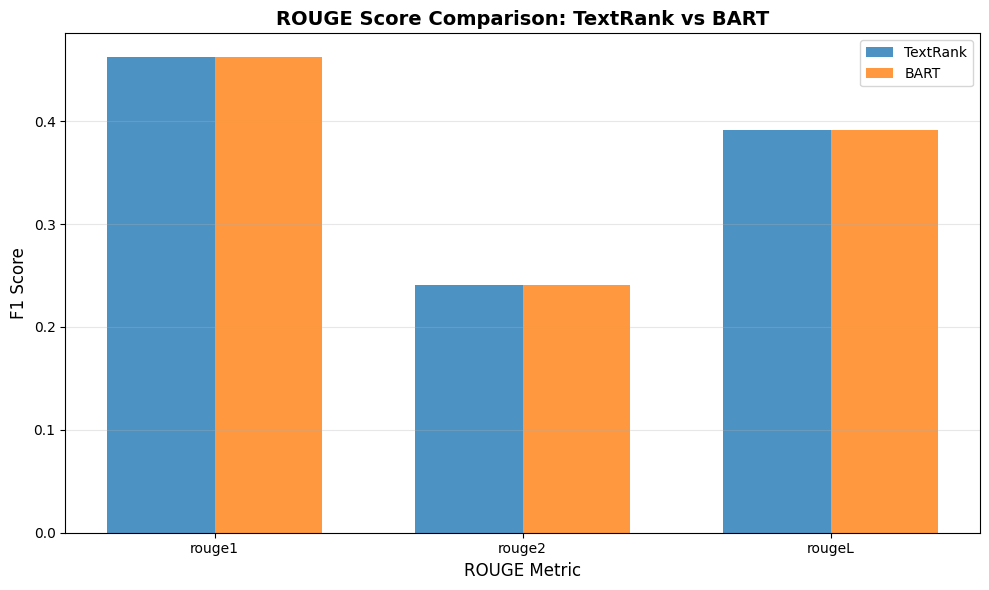

Saved: ./results/rouge_comparison.png


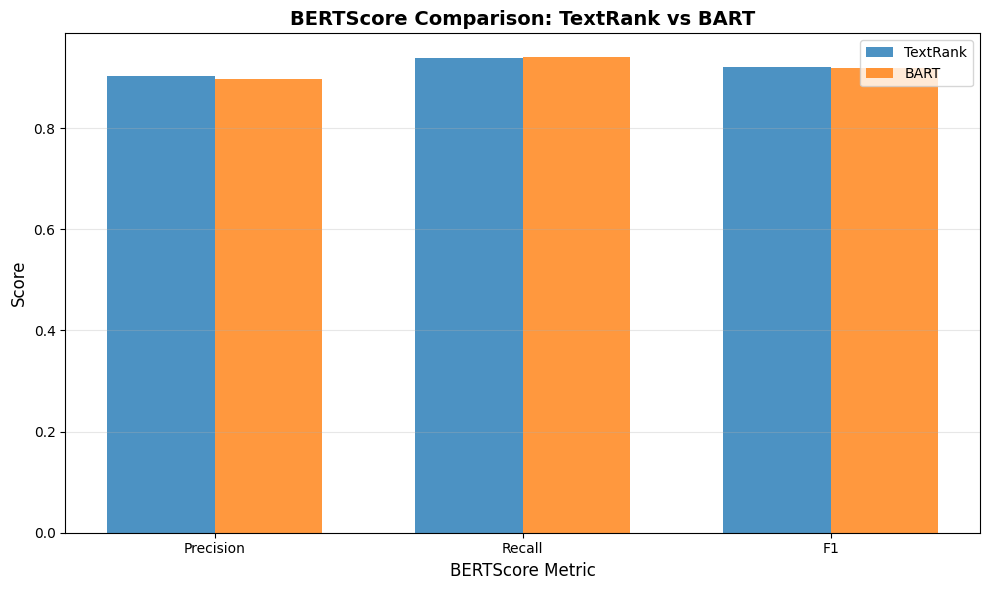

Saved: ./results/bertscore_comparison.png


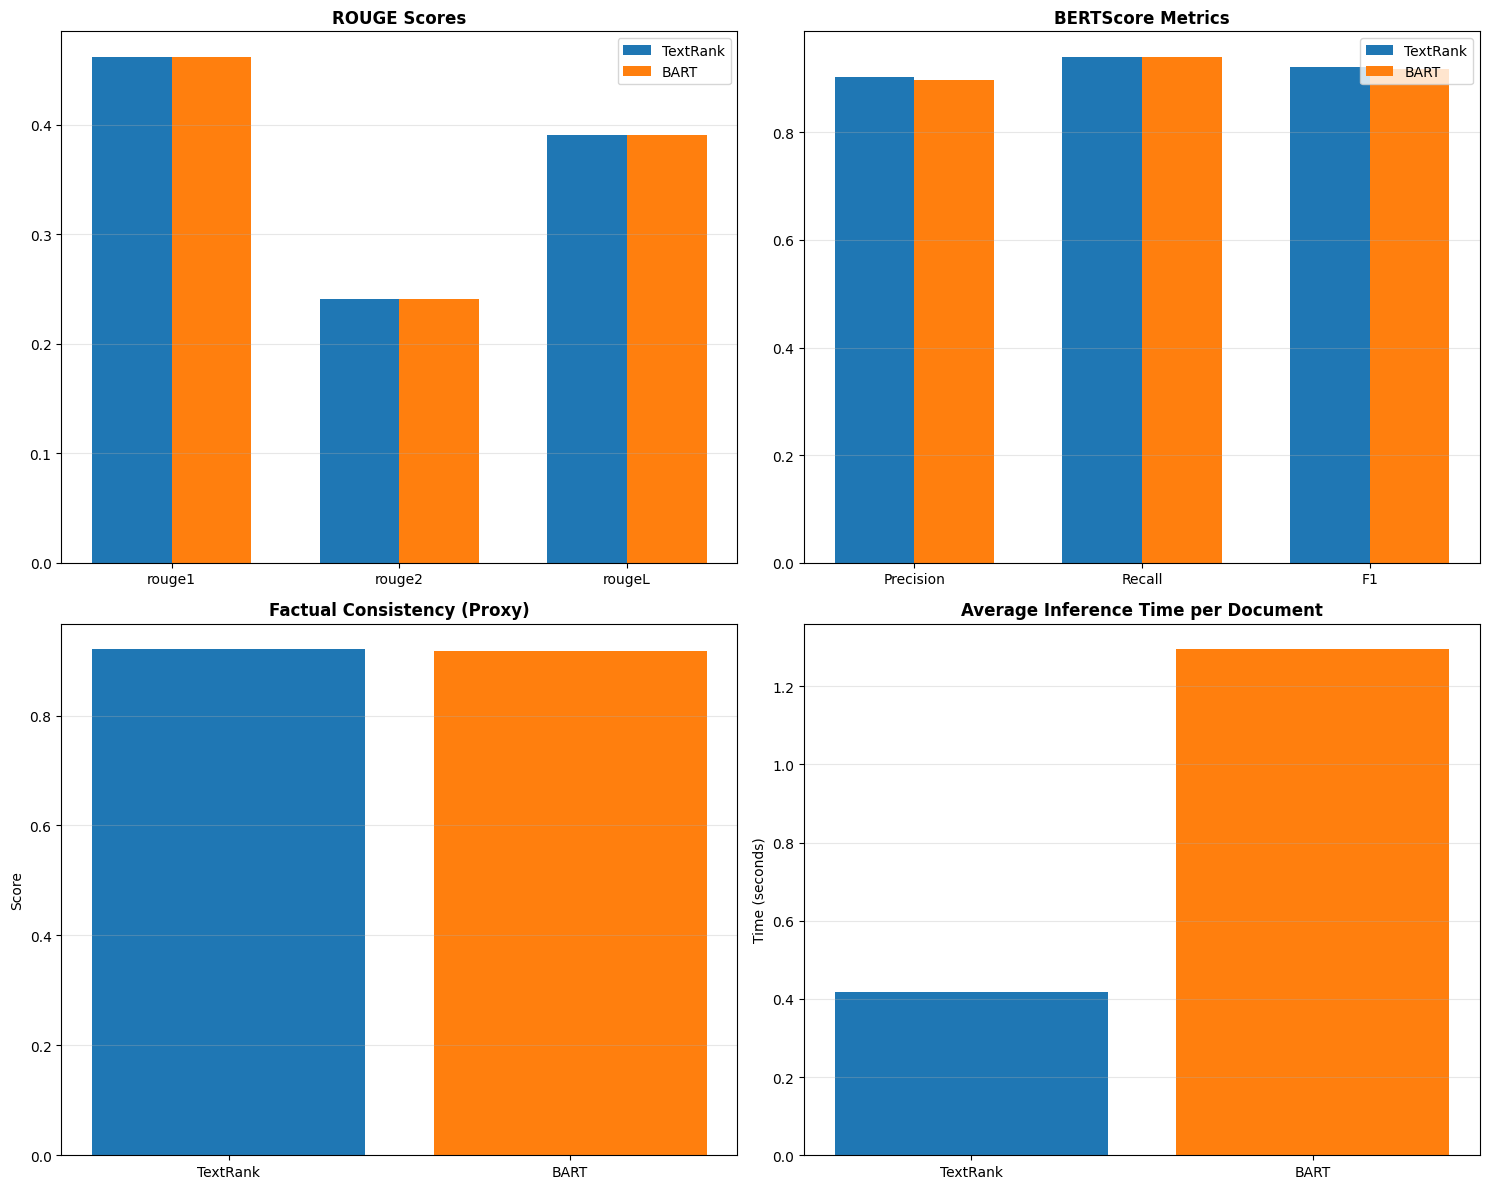

Saved: ./results/overall_comparison.png
Saved: ./results/summary_comparison.csv
FINANCIAL TEXT SUMMARIZATION - EVALUATION REPORT

Generated: 2025-12-25 07:18:17



TextRank Results:
----------------------------------------
ROUGE-1: 0.4623
ROUGE-2: 0.2406
ROUGE-L: 0.3910
BERTScore F1: 0.9209
Factual Consistency: 0.9209

BART Results:
----------------------------------------
ROUGE-1: 0.4623
ROUGE-2: 0.2406
ROUGE-L: 0.3910
BERTScore F1: 0.9183
Factual Consistency: 0.9183

Comparative Analysis:
----------------------------------------
BART performs better on: None
TextRank performs better on: rouge1, rouge2, rougeL

Saved: ./results/evaluation_report.txt

Step 7: Sample Summary Comparison

Document 1:
----------------------------------------
Original (excerpt): The Company reported strong financial results for Q4 2023, with revenue 
            increasing 25% year-over-year to $5.2 billion. Net income reached...

Reference: The Company achieved 25% revenue growth to $5.2B in Q4 2023, with 

'\nUSAGE INSTRUCTIONS:\n===================\n\n1. GOOGLE COLAB SETUP:\n   - Upload this file to Colab\n   - Run the installation cell first\n   - Enable GPU: Runtime > Change runtime type > GPU\n   - Run setup_colab_environment() to mount Drive\n   - Run main()\n\n2. KAGGLE SETUP:\n   - Create new notebook\n   - Copy this code\n   - Enable GPU/TPU in settings\n   - Run main()\n\n3. LOCAL SETUP:\n   - Install requirements: pip install -r requirements.txt\n   - Ensure you have GPU with CUDA support\n   - Run: python financial_summarization.py\n\n4. CUSTOM DATA:\n   - Replace load_sample_data() with your SEC data loader\n   - Ensure data format: List[str] for documents and references\n   - Minimum recommended: 100+ documents for meaningful results\n\n5. FINE-TUNING BART:\n   - Set train_bart=True in run_complete_pipeline()\n   - Requires more time and GPU memory\n   - Recommended for production use\n\n6. EVALUATION:\n   - Results saved in ./results directory\n   - Visualizations: PNG file

In [16]:
# ============================================================================
# EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Uncomment the function you want to run:

    # Full pipeline
    main()

    # Quick test
    # quick_test()

    # Setup Colab environment
    # setup_colab_environment()
    # main()


"""
USAGE INSTRUCTIONS:
===================

1. GOOGLE COLAB SETUP:
   - Upload this file to Colab
   - Run the installation cell first
   - Enable GPU: Runtime > Change runtime type > GPU
   - Run setup_colab_environment() to mount Drive
   - Run main()

2. KAGGLE SETUP:
   - Create new notebook
   - Copy this code
   - Enable GPU/TPU in settings
   - Run main()

3. LOCAL SETUP:
   - Install requirements: pip install -r requirements.txt
   - Ensure you have GPU with CUDA support
   - Run: python financial_summarization.py

4. CUSTOM DATA:
   - Replace load_sample_data() with your SEC data loader
   - Ensure data format: List[str] for documents and references
   - Minimum recommended: 100+ documents for meaningful results

5. FINE-TUNING BART:
   - Set train_bart=True in run_complete_pipeline()
   - Requires more time and GPU memory
   - Recommended for production use

6. EVALUATION:
   - Results saved in ./results directory
   - Visualizations: PNG files
   - Metrics: TXT and CSV files
   - Models: Saved in ./models directory

For questions or issues, refer to the project documentation.
"""